# [Fe/H] Metallicity Profiles

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import json
from scipy.stats import binned_statistic
from scipy.stats import linregress
from scipy.optimize import curve_fit
from itertools import product

In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup, set_axs_configuration
from auriga.settings import Settings
from auriga.parser import parse
from auriga.physics import Physics
from auriga.mathematics import linear

In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(
    color=list(mcolors.TABLEAU_COLORS.values()))

In [48]:
figure_setup()
settings = Settings()

In [5]:
RXY_RANGE: tuple = (0, 30)
N_BINS: int = 30

In [6]:
def read_snapshot_data(simulation: str, of: str,
                       to: str, band: str = None) -> tuple:
    """
    This method returns data of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.
    of : str
        The metal of which to calculate the metallicity.
    to : str
        The metal to which to calculate the metallicity.
    band : str, optional
        The optical band for the luminosity calculation. If band is not
        provided, luminosities will not be added to the data.

    Returns
    -------
    pd.DataFrame
        A data frame with the properties.
    """

    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[4])
    s.add_extra_coordinates()
    s.add_metal_abundance(of=of, to=to)
    s.add_stellar_age()
    s.add_stellar_photometrics()

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    df = pd.DataFrame()
    df[f"[{of}/{to}]_dex"] = s.metal_abundance[f"{of}/{to}"][
        is_real_star & is_main_obj]
    df["CylindricalRadius_ckpc"] = s.rho[is_real_star & is_main_obj]
    df["StellarAge_Gyr"] = s.stellar_age[is_real_star & is_main_obj]

    if band is not None:  # Load luminosities if a band was provided
        s.add_luminosities(band=band)
        df["Luminosity_W"] = s.stellar_luminosities[is_real_star & is_main_obj]

    # Remove invalid data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

In [7]:
def calc_mean_stat(x, y, n_bins: int, xrange: tuple, weights = None):
    if weights is None: weights = np.ones(x.shape)

    num = binned_statistic(x=x, values=y * weights,
        statistic="sum", bins=n_bins, range=xrange)[0]
    den = binned_statistic(x=x, values=weights,
        statistic="sum", bins=n_bins, range=xrange)[0]
    mean = num / den

    std, bin_edges, _ = binned_statistic(
        x=x, values=y, statistic="std", bins=n_bins, range=xrange)
    count, _, _ = binned_statistic(
        x=x, values=y, statistic="count", bins=n_bins, range=xrange)
    err = std / np.sqrt(count)

    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    return bin_centers, mean, err

In [8]:
def read_sample_data(galaxies: list, band: str = None) -> pd.DataFrame:
    df = pd.DataFrame()
    for galaxy in galaxies:
        gdf = read_snapshot_data(
            simulation=galaxy, of="Fe", to='H', band=band)
        if band is not None:  # Set weights for binned data
            weights = gdf["Luminosity_W"]
        else:
            weights = np.ones(len(gdf))
        bin_centers, mean, _ = calc_mean_stat(
            x=gdf["CylindricalRadius_ckpc"], y=gdf["[Fe/H]_dex"],
            weights=weights, n_bins=N_BINS, xrange=RXY_RANGE)
        df[f"{galaxy.upper()}_<[Fe/H]>_dex"] = mean
    df["BinCenters_ckpc"] = bin_centers
    return df

## [Fe/H] Profiles

In [84]:
sample = [f"au{i}_or_l4_s127" for i in settings.galaxies]
df = read_sample_data(galaxies=sample)

In [85]:
df["SampleAverage_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].mean(axis=1)
df["SampleDispersion_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].std(axis=1)

### Sample + Average

In [11]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>$")

ax.grid(True, ls='-', lw=0.25, c='silver')

for galaxy in sample:
    ax.plot(df["BinCenters_ckpc"], df[f"{galaxy.upper()}_<[Fe/H]>_dex"],
            lw=1, color="gainsboro", zorder=10)

ax.plot(df["BinCenters_ckpc"], df["SampleAverage_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11)
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] - df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] + df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")

fig.savefig(
    f"../images/FeH_metallicity_profiles/originals_average_total.pdf")
plt.close(fig)

### Gradient Comparison

In [79]:
data1 = json.load(open("../data/genovali_2014.json"))
data2 = json.load(open("../data/lemasle_2007.json"))
data3 = json.load(open("../data/lemasle_2008.json"))
data4 = json.load(open("../data/lemasle_2018.json"))

In [80]:
print(data1["Notes"],  # 4 - 15 kpc
    data2["Notes"],  # 8 - 12 kpc
    data3["Notes"],  # 8 - 15 kpc
    data4["Notes"],  # 6 - 14 kpc
    sep="\n")
fit_range = (4, 15)

The current data set covers a range in Galactocentric distances of more than 10 kpc (4 <= RG <= 15 kpc). We estimated the metallicity gradient (dashed line) and we found [Fe/H] = 0.49 +/- 0.03 − 0.051 +/- 0.003 RG / kpc. The new slope and zero-point agree quite well with similar estimates available in the literature (Luck & Lambert 2011; Lemasle et al. 2013).
Data plotted in the top panel of Fig. 7 show that the slope is –0.061 dex/kpc in the region ranging from ~8 to ~12 kpc.
The 63 stars of this sample are located between 8 and 15 kpc from the Galactic center (see Fig. 3). We investigated at first the working hypothesis of a linear gradient and calculated the iron Galactic gradient using the entire Cepheid sample. We found a slope of –0.023 +/- 0.007 dex/kpc that is shallower than previous studies.
With the bootstrap method, we obtain a slope of −0.0447 +/- 0.0066 dex/kpc for the gradient (see Fig. 6). [...] The agreement remains reasonable with the total least squares method (Fig. 8

In [86]:
# Fit sample in the range
range_fits = []
for galaxy in sample:
    x = df["BinCenters_ckpc"].to_numpy()
    y = df[f"{galaxy.upper()}_<[Fe/H]>_dex"].to_numpy()
    x_range = x[(x > fit_range[0]) & (x < fit_range[1])]
    y_range = y[(x > fit_range[0]) & (x < fit_range[1])]
    regress = linregress(x=x_range, y=y_range)
    range_fits.append(regress)

In [87]:
# Fit of the sample average
x = df["BinCenters_ckpc"].to_numpy()
y = df[f"SampleAverage_<[Fe/H]>_dex"].to_numpy()

x_range = x[(x > fit_range[0]) & (x < fit_range[1])]
y_range = y[(x > fit_range[0]) & (x < fit_range[1])]
sample_fit = linregress(x=x_range, y=y_range)

In [88]:
y_delta = 0.02

y_data = [0]
x_data = [sample_fit.slope]
x_data_err = [sample_fit.stderr]
y_label = [r"\textbf{Auriga}"]
c = ['k']

for i, fit in enumerate(range_fits):
    y_data.append(- y_delta * i)
    x_data.append(fit.slope)
    x_data_err.append(fit.stderr)
    y_label.append(f"Au{i + 1}")
    c.append("gainsboro")

In [ ]:
fig, axs = plt.subplots(figsize=(7.2, 4.0), ncols=2,
                       gridspec_kw={"wspace": 0.3})

axs[0].set_xlim(-0.1, 0.02)
axs[0].set_ylim(-0.7, 0.02)
axs[0].set_xlabel(r"$\nabla \mathrm{[Fe/H]}$ [dex/kpc]")
axs[0].set_yticks([- i * 0.02 for i in range(35)])
axs[0].set_yticklabels([])

axs[1].set_xlim(0, 30)
axs[1].set_ylim(-0.6, 0.6)
axs[1].set_xlabel(r"$r_{xy}$ [ckpc]")
axs[1].set_ylabel(r"$\mathrm{[Fe/H]}$")

for ax in axs: ax.grid(True, ls='-', lw=0.25, c='gainsboro')

axs[0].errorbar(
    sample_fit.slope, 0, xerr=sample_fit.stderr,
    markeredgecolor="white", capsize=2, capthick=1, color='k',
    marker='o', markersize=4, linestyle='none', zorder=10)

for i, fit in enumerate(range_fits):
    axs[0].errorbar(
        fit.slope, 0 - 0.02 * (i + 1),
        xerr=fit.stderr, color="gray",
        markeredgecolor="white", capsize=2, capthick=1,
        marker='o', markersize=4, linestyle='none', zorder=10)
    axs[0].text(
        x=-0.105, y=0 - 0.02 * (i + 1), size=6.0, color="gray",
        ha="right", va="center", s=f"Au{i + 1}")

axs[0].errorbar(
    data1["Data"]["Slope"], - 0.02 * 31, xerr=data1["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data2["Data"]["Slope"], - 0.02 * 32, xerr=data2["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data3["Data"]["Slope"], - 0.02 * 33, xerr=data3["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data4["Data"]["BootstrapSlope"], - 0.02 * 34,
    xerr=data4["Data"]["BootstrapSlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)

axs[0].text(x=-0.105, y=0, size=6.0, color='k',
            ha="right", va="center", s="Auriga Average")

axs[0].text(x=-0.105, y=- 0.02 * 31, size=6.0, color="tab:blue",
            ha="right", va="center", s="Genovali et al. (2014)")
axs[0].text(x=-0.105, y=- 0.02 * 32, size=6.0, color="tab:orange",
            ha="right", va="center", s="Lemasle et al. (2007)")
axs[0].text(x=-0.105, y=- 0.02 * 33, size=6.0, color="tab:green",
            ha="right", va="center", s="Lemasle et al. (2008)")
axs[0].text(x=-0.105, y=- 0.02 * 34, size=6.0, color="tab:red",
            ha="right", va="center", s="Lemasle et al. (2018)")

axs[0].plot([0] * 2, axs[0].get_ylim(), ls="--", lw=0.75, color='k', zorder=10)

axs[1].plot(axs[1].get_xlim(), [0] * 2, ls="--", lw=0.75, color='k', zorder=10)
x = np.linspace(0, 30, 100)
for fit in range_fits:
    axs[1].plot(x, x * fit.slope, color="grey",lw=1, zorder=10)
axs[1].plot(x, x * sample_fit.slope, color='k', lw=1, zorder=11)
axs[1].plot(x, x * data1["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data2["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data3["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data4["Data"]["BootstrapSlope"], lw=1, zorder=11)

fig.savefig(
    f"../images/FeH_metallicity_profiles/mw_comparison/slope_data_range.pdf")
plt.close(fig)

### Gradient vs. Stellar Mass

In [41]:
gal_df = pd.read_csv("../data/grand_2017.csv",
                     usecols=["Run", "StellarMass_10^10Msun"])
gal_df["Resolution"] = gal_df["Run"].str.split("_L").str[1].astype(np.uint8)
gal_df["Run"] = gal_df["Run"].astype(str)
gal_df = gal_df[gal_df["Resolution"] == 4]

In [42]:
metallicity_gradients = []
for fit in range_fits:
    metallicity_gradients.append(fit.slope)
gal_df["MetallicityGradient_dex/kpc"] = metallicity_gradients

In [44]:
gal_df

,Run,StellarMass_10^10Msun,Resolution,MetallicityGradient_dex/kpc
0,Au1_L4,2.75,4,-0.012162
1,Au2_L4,7.05,4,0.002903
2,Au3_L4,7.75,4,-0.001055
3,Au4_L4,7.10,4,-0.022897
4,Au5_L4,6.72,4,-0.013560
5,Au6_L4,4.75,4,-0.007863
6,Au7_L4,4.88,4,-0.013192
7,Au8_L4,2.99,4,-0.004585
8,Au9_L4,6.10,4,-0.014842
9,Au10_L4,5.94,4,-0.034590


In [73]:
import statsmodels as sm

X = pd.DataFrame()
X["StellarMass_10^10Msun"] = gal_df["StellarMass_10^10Msun"]
X["Intercept"] = np.ones(gal_df.shape[0])
y = gal_df["MetallicityGradient_dex/kpc"]

In [ ]:
model = sm.regression.linear_model.OLS(y, X)
res = model.fit()

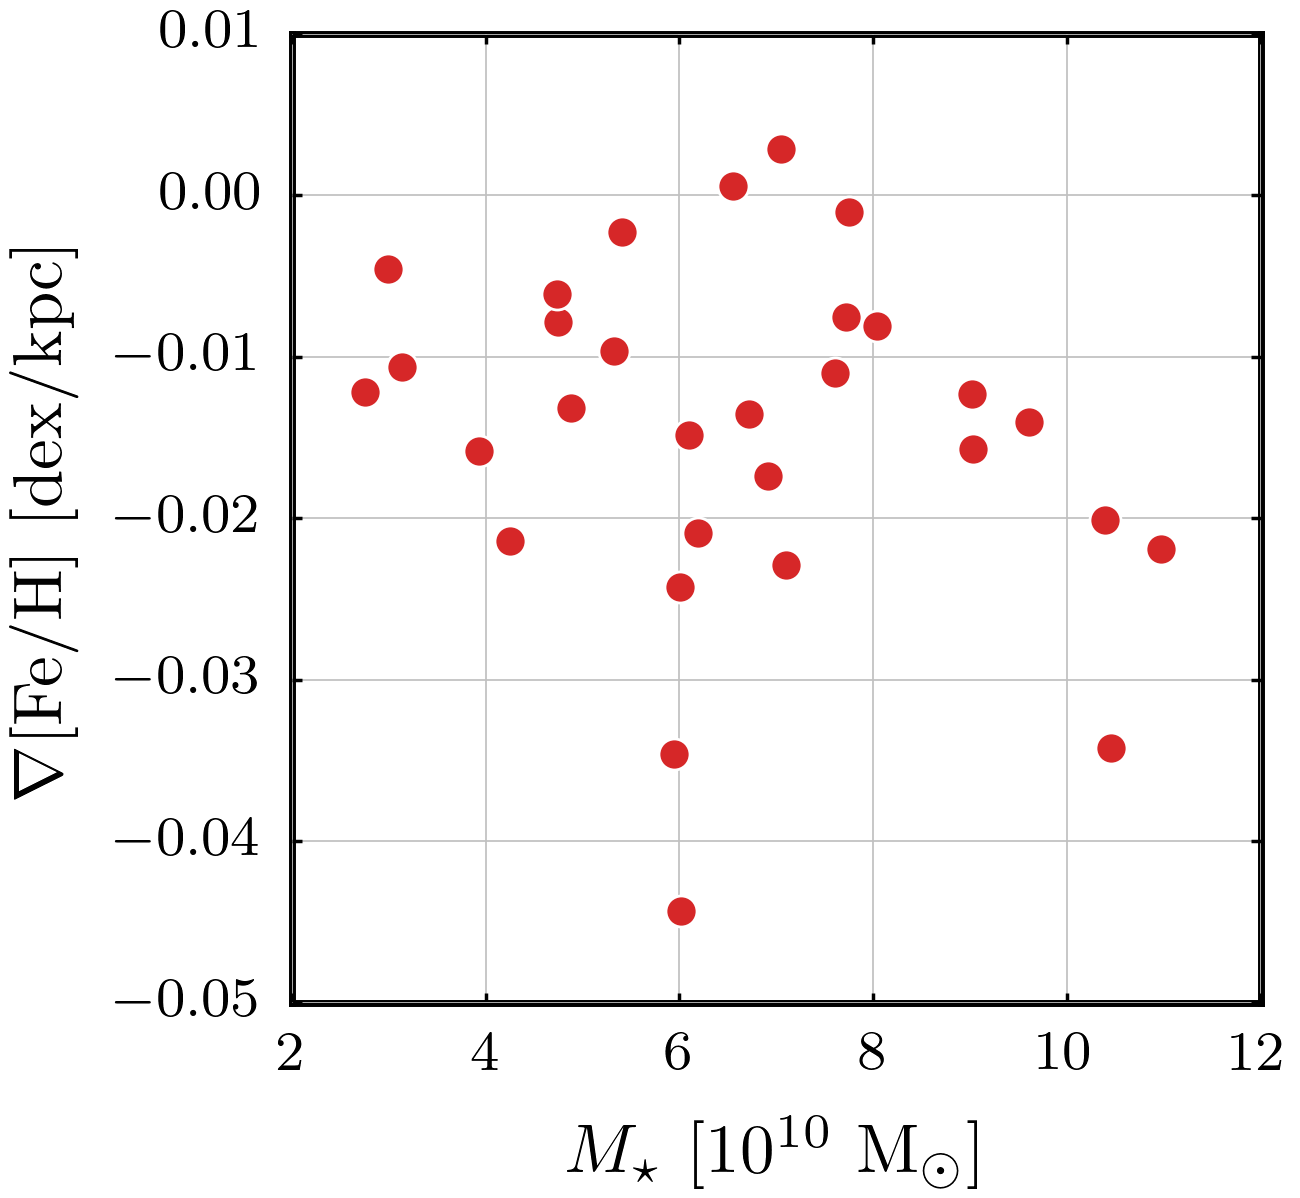

In [56]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# ax.set_xlim(0, 30)
# ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$M_\star$ [$10^{10} ~ \mathrm{M}_\odot$]")
ax.set_ylabel(r"$\nabla \mathrm{[Fe/H]}$ [dex/kpc]")

ax.grid(True, ls='-', lw=0.25, c='silver')

ax.scatter(
    gal_df["StellarMass_10^10Msun"],
    gal_df["MetallicityGradient_dex/kpc"],
    c="tab:red", s=20, linewidths=0.4, edgecolors="white", zorder=10)

plt.show()

### By SSP Age

In [75]:
age_ranges = [(2 * i, 2 * i + 2) for i in range(7)]

In [19]:
fig = plt.figure(figsize=(7.2, 7.2))
gs = fig.add_gridspec(nrows=6, ncols=5, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for i, galaxy in enumerate(settings.galaxies):
    simulation = f"au{galaxy}_or_l4_s127"
    ax = axs.flatten()[i]

    # Set up current ax
    ax.grid(True, ls='-', lw=0.2, c="gainsboro", zorder=-10)
    ax.set_xlim(RXY_RANGE)
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    ax.set_ylim(-1, 1)
    ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>$")
    ax.set_xlabel(r"$r_{xy}$ [ckpc]")
    ax.tick_params(axis="both", labelsize=8.0)
    ax.label_outer()

    df = read_snapshot_data(simulation=simulation, of="Fe", to="H")

    ax.text(x=0.95, y=0.95, size=6.0,
            s=r"$\texttt{" + f"au{galaxy}_or_l4_s127".upper() + "}$",
            ha='right', va='top', transform=ax.transAxes)

    for age_range in age_ranges:
        is_age = (df["StellarAge_Gyr"] >= age_range[0]) \
            & (df["StellarAge_Gyr"] < age_range[1])
        
        label = f"{age_range[0]} - {age_range[1]}"
        bin_centers, mean, _ = calc_mean_stat(
            x=df["CylindricalRadius_ckpc"][is_age], y=df["[Fe/H]_dex"][is_age],
            n_bins=N_BINS, xrange=RXY_RANGE)

        ax.plot(bin_centers, mean, label=label, zorder=10)

        fig.savefig(f"../images/FeH_metallicity_profiles/by_ssp_age.pdf")

    if galaxy == 1:
        ax.legend(loc=(0.3, 0.5), framealpha=0.0, fontsize=3.0,
                  ncol=2, title="Age [Gyr]", title_fontsize=4.0)

fig.savefig(f"../images/FeH_metallicity_profiles/by_ssp_age.pdf")
plt.close(fig)

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [76]:
age_ranges = [(i, i + 1) for i in range(14)]
fit_data = []

In [77]:
# Fits for different stellar ages
for galaxy in settings.galaxies:
    simulation = f"au{galaxy}_or_l4_s127"
    df = read_snapshot_data(simulation=simulation, of="Fe", to="H")
    for age_range in age_ranges:
        is_age = (df["StellarAge_Gyr"] >= age_range[0]) \
                 & (df["StellarAge_Gyr"] < age_range[1])
        model = linregress(x=df["CylindricalRadius_ckpc"][is_age],
                           y=df["[Fe/H]_dex"][is_age])
        fit_data.append([galaxy, age_range, model])

In [78]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 14)
ax.set_ylim(-0.07, 0)
ax.set_xlabel("Stellar Age [Gyr]")
ax.set_ylabel(r"$\nabla \mathrm{[Fe/H]}$ [dex/kpc]")
ax.tick_params(axis="both", labelsize=8.0)

ax.grid(True, ls='-', lw=0.25, c="gainsboro")

for i in range(len(fit_data)):
    c = "silver"
    zorder = 10
    if fit_data[i][0] == 6:
        c = "tab:blue"
        zorder = 11
    if fit_data[i][0] == 9:
        c = "tab:red"
        zorder = 11
    ax.plot(np.mean(fit_data[i][1]), fit_data[i][2].slope,
            markersize=3, marker='o', lw=0,
            markeredgewidth=0, markerfacecolor=c, color=c, zorder=zorder)

ax.text(x=0.95, y=0.1, size=7.0, c="tab:blue",
        s=r"$\texttt{" + f"au6_or_l4_s127".upper() + "}$",
        ha="right", va="bottom", transform=ax.transAxes)
ax.text(x=0.95, y=0.04, size=7.0, c="tab:red",
        s=r"$\texttt{" + f"au9_or_l4_s127".upper() + "}$",
        ha="right", va="bottom", transform=ax.transAxes)


fig.savefig(f"../images/FeH_metallicity_profiles/slope_vs_ssp_age.pdf")
plt.close(fig)

## Luminosity-Weighted [Fe/H] Profiles

### Au6 - All Bands

In [23]:
galaxy = "au6_or_l4_s127"
df = pd.DataFrame()
for band in settings.photometric_bands:
    gdf = read_sample_data(galaxies=[galaxy], band=band)
    gdf = gdf.rename(
        columns={f"{galaxy.upper()}_<[Fe/H]>_dex": f"<[Fe/H]>_Band{band}_dex"})
    if "BinCenters_ckpc" not in df.columns:
        df = pd.concat([df, gdf["BinCenters_ckpc"]], axis=1)    
    df = pd.concat([df, gdf[f"<[Fe/H]>_Band{band}_dex"]], axis=1)


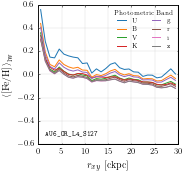

In [24]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

for band in settings.photometric_bands:
    ax.plot(
        df["BinCenters_ckpc"], df[f"<[Fe/H]>_Band{band}_dex"],
        lw=1.0, zorder=10, ls='-', label=band)

ax.text(
    x=0.05, y=0.05, size=7.0,
    s=r"$\texttt{" + "au6_or_l4_s127".upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0, ncol=2,
          title="Photometric Band", title_fontsize=6.0)

plt.show()

### Au6 - All Bands + Fits

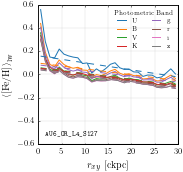

In [25]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

regressions = []
for i, band in enumerate(settings.photometric_bands):
    x = df["BinCenters_ckpc"].to_numpy()
    y = df[f"<[Fe/H]>_Band{band}_dex"].to_numpy()

    x_range = x[(x >= fit_range[0]) & (x >= fit_range[1])]
    y_range = y[(x >= fit_range[0]) & (x >= fit_range[1])]
    regress = linregress(x=x_range, y=y_range)
    regressions.append(regress)
    ax.plot(x, linear(x, regress.slope, regress.intercept),
        lw=1.0, zorder=10, ls='--',
        color=list(mcolors.TABLEAU_COLORS.values())[i])

    ax.plot(x, y, lw=1.0, zorder=9, ls='-', label=band, 
            color=list(mcolors.TABLEAU_COLORS.values())[i])

ax.text(
    x=0.05, y=0.05, size=7.0,
    s=r"$\texttt{" + "au6_or_l4_s127".upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0, ncol=2,
          title="Photometric Band", title_fontsize=6.0)

plt.show()

### Comparison With Lian+2023 (K-band)

In [26]:
df_exp = pd.read_csv("../data/lian_2023/MW_Z_prof.txt", delimiter=' ')

In [27]:
df = read_sample_data(galaxies=sample, band='K')

In [28]:
df["SampleAverage_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].mean(axis=1)
df["SampleDispersion_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].std(axis=1)

In [29]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

# Weighted profile for all galaxies
for galaxy in sample:
    ax.plot(df["BinCenters_ckpc"], df[f"{galaxy.upper()}_<[Fe/H]>_dex"],
            lw=0.7, zorder=10, c="gainsboro", ls='-')

ax.plot(df["BinCenters_ckpc"], df[f"AU2_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1, zorder=10, c="tab:green", ls='-',
        label=r"$\texttt{" + "au2_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"], df[f"AU6_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1, zorder=10, c="tab:blue", ls='-',
        label=r"$\texttt{" + "au6_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"], df[f"AU11_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1, zorder=10, c="tab:purple", ls='-',
        label=r"$\texttt{" + "au11_or_l4_s127".upper() + "}$")

ax.plot(df["BinCenters_ckpc"], df["SampleAverage_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11)
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] - df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] + df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")

# Experimental data
ax.errorbar(df_exp["radius"], df_exp["total"], yerr=df_exp["total_err"],
            fmt="-o", capthick=0, color="tab:red", markersize=2.5,
            markeredgecolor="tab:red", zorder=10, label="Lian et al. (2023)",
            lw=0.7)

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0)

fig.savefig(f"../images/FeH_metallicity_profiles/mw_comparison/profiles.pdf")
plt.close(fig)

In [30]:
dfg = pd.read_csv("../data/grand_2017.csv")
mw_effective_radius_min = 3.4  # kpc
mw_effective_radius_max = 6.7  # kpc
mw_effective_radius_mean = np.mean([
    mw_effective_radius_min, mw_effective_radius_max])

In [31]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 5)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [$R_\mathrm{eff}$]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

# Weighted profile for all galaxies
for galaxy in sample:
    dfg_label = galaxy.split('_')[0].capitalize()
    effective_radius = float(
        dfg["RadialScalelength_kpc"][dfg["Run"] == f"{dfg_label}_L4"])
    ax.plot(df["BinCenters_ckpc"] / effective_radius,
            df[f"{galaxy.upper()}_<[Fe/H]>_dex"],
            lw=0.7, zorder=10, c="gainsboro", ls='-')

ax.plot(df["BinCenters_ckpc"] / float(dfg[
        "RadialScalelength_kpc"][dfg["Run"] == "Au2_L4"]),
        df[f"AU2_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1.0, zorder=10, c="tab:green", ls='-',
        label=r"$\texttt{" + f"au2_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"] / float(dfg[
        "RadialScalelength_kpc"][dfg["Run"] == "Au6_L4"]),
        df[f"AU6_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1.0, zorder=10, c="tab:blue", ls='-',
        label=r"$\texttt{" + f"au6_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"] / float(dfg[
        "RadialScalelength_kpc"][dfg["Run"] == "Au11_L4"]),
        df[f"AU11_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1.0, zorder=10, c="tab:purple", ls='-',
        label=r"$\texttt{" + f"au6_or_l4_s127".upper() + "}$")

# Experimental data
x1 = df_exp["radius"] / mw_effective_radius_min
x_mean = df_exp["radius"] / mw_effective_radius_mean
x2 = df_exp["radius"] / mw_effective_radius_max
ax.errorbar(x_mean, df_exp["total"],
            yerr=df_exp["total_err"],
            fmt="-o", capthick=0, color="tab:red", markersize=2.5,
            markeredgecolor="tab:red", zorder=10, label="Lian et al. (2023)",
            lw=0.7)
ax.fill_betweenx(y=df_exp["total"].to_numpy()[-9:],
                  x1=x1.to_numpy()[-9:], x2=x2.to_numpy()[-9:],
                  interpolate=True, color="#f3bfbf")
ax.fill_betweenx(y=df_exp["total"], x1=x1, x2=x2,
                 interpolate=True, color="#f3bfbf")

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0)

fig.savefig(
    f"../images/FeH_metallicity_profiles/mw_comparison/profiles_eff_radius.pdf")
plt.close(fig)